In [14]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
root="../own_dataset/split/"

import matplotlib.pyplot as plt
%matplotlib inline

crop_size = 424
batch_size = 5
crop_num = 2

In [15]:
torch.cuda.is_available()

True

In [23]:
# -----------------ready the dataset--------------------------
def default_loader(path):
    return Image.open(path).convert("L")
class MyDataset(Dataset):
    def __init__(self, txt, crop_size,crop_num, transform=None, target_transform=None, loader=default_loader):
        fh = open(txt, 'r')
        imgs = []
        gts = []
        lines = fh.read().split()
        for i, line in enumerate(lines):
            line = str(line)
            for j in range(0,crop_num):
                imgs.append('../own_dataset/input/'+line+'.jpg')
                gts.append('../own_dataset/output/'+line+'.png')
        self.imgs = imgs
        self.gts = gts
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.crop = crop_size

    def __getitem__(self, index):
        fn = self.imgs[index]
        img = self.loader(fn)
        gt = self.gts[index]
        gt_img = self.loader(gt)
        w,h = gt_img.size
        if w<crop_size or h<crop_size:
            width = w
            height = h
            if w <= h:
                width = crop_size
                height = float(height/w) * crop_size
                height = int(height)
#                 print height
            else:
                height = crop_size
                width = float(width / h) * crop_size
                width = int(width)
#                 print width
            img = img.resize((width, height),Image.NEAREST)  
            gt_img = gt_img.resize((width,height),Image.NEAREST)
        w,h = gt_img.size
        if self.crop !=-1:
            x1, y1 = random.randint(0, w - self.crop), random.randint(0, h - self.crop)
            img, gt_img = img.crop((x1, y1, x1 + self.crop, y1 + self.crop)), gt_img.crop((x1, y1, x1 + self.crop, y1 + self.crop))

#         plt.figure()
#         plt.imshow(gt_img,cmap ='gray')
#         plt.figure()
#         plt.imshow(img,cmap ='gray')
        
        if self.transform is not None:
            img = self.transform(img)
            gt_img = self.transform(gt_img)
                  
        return img,gt_img

    def __len__(self):
        return len(self.imgs)

In [24]:
train_data=MyDataset(root+'train2.txt', crop_size,crop_num, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,drop_last = True)
test_data=MyDataset(root+'val2.txt', -1, 1,transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_data, batch_size=1)
print(len(train_data))
print(len(train_loader))

152
30


In [25]:
# for batch_x, batch_y in train_loader:
#     print(batch_x.size())
#     print(batch_y.size())

In [26]:
#-----------------create the Net and training------------------------

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.downconv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 48, 5, 2, 2),
            torch.nn.BatchNorm2d(48),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(48, 128, 3, 1, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(128, 128, 3, 1, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        self.downconv2 = torch.nn.Sequential(
            torch.nn.Conv2d(128,256, 3, 2, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 256, 3, 1, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 256, 3, 1, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        self.downconv3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, 3, 2, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 512, 3, 1, 1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(512, 1024, 3, 1, 1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
        )
        self.flat = torch.nn.Sequential(
            torch.nn.Conv2d(1024, 1024, 3, 1, 1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(1024, 1024, 3, 1, 1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(1024, 1024, 3, 1, 1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(1024, 512, 3, 1, 1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),

            torch.nn.Conv2d(512, 256, 3, 1, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.upconv1 = torch.nn.Sequential(
#             torch.nn.Conv2d(256, 256, 4, 0.5, 1),
            torch.nn.ConvTranspose2d(256, 256, 4, 2, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 256, 3, 1, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 128, 3, 1, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        self.upconv2 = torch.nn.Sequential(
#             torch.nn.Conv2d(128, 128, 4, 0.5, 1),
            torch.nn.ConvTranspose2d(128, 128, 4, 2, 1),            
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(128, 128, 3, 1, 1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(128, 48, 3, 1, 1),
            torch.nn.BatchNorm2d(48),
            torch.nn.ReLU(),
        )
        self.upconv3 = torch.nn.Sequential(
#             torch.nn.Conv2d(48, 48, 4, 0.5, 1),
            torch.nn.ConvTranspose2d(48, 48,4, 2, 1),
            torch.nn.BatchNorm2d(48),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(48, 24, 3, 1, 1),
            torch.nn.BatchNorm2d(24),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(24, 1, 3, 1, 1),
            torch.nn.Sigmoid (),
        )


    def forward(self, x):
        conv1_out = self.downconv1(x)
        conv2_out = self.downconv2(conv1_out)
        conv3_out = self.downconv3(conv2_out)
        flat_out = self.flat(conv3_out)
        upconv1_out = self.upconv1(flat_out)
        upconv2_out = self.upconv2(upconv1_out)
        upconv3_out = self.upconv3(upconv2_out)
        return upconv3_out

In [27]:
class OwnLossFunc(torch.nn.Module):
    def __init__(self):
        super(OwnLossFunc,self).__init__()
        return
    
    def forward(self,pred,gt):
        dis = torch.abs(pred-gt)
        sqr = torch.pow(dis,2).sum()
#         loss = torch.pow(sqr,0.5)
        size = pred.size()
        all_pix_c = 1
        for s in size:
            all_pix_c = all_pix_c*s 
        loss = sqr / all_pix_c
        return loss

In [28]:
import os
from time import time
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
model = torch.nn.DataParallel(Net().cuda())
# print(model)
optimizer = torch.optim.Adadelta(model.parameters())
loss_func = OwnLossFunc().cuda()

In [32]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
for epoch in range(3):
    # training-----------------------------
    train_loss = 0.
    train_acc = 0.
    start = time()
    for batch_x, batch_y in train_loader:
#         print(batch_x)
#         print(batch_y)
        batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
        out = model(batch_x)
#         print(batch_x.size())
#         print(out.size())
        loss = loss_func(out, batch_y)
        train_loss += loss.data[0]
        pred = out
#         print(pred)
#         print(batch_y)
        size = pred.size()
        all_pix = 1
        for s in size:
            all_pix = all_pix*s 
        acc = (torch.abs(pred - batch_y)>0.01).sum()/all_pix
        train_acc +=acc.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch %d. Loss: %.6f, Train acc %.2f, Time %.1f sec" % (
            epoch+1, train_loss / (len(train_data)), train_acc / len(train_data), time() - start
        ))
    
    if epoch % 1 ==0:
#         PATH = 'model/epoch-'+str(epoch)
#         torch.save(model, PATH)

        idx = 0
        for batch_x, batch_y in test_loader:
            idx = idx+1
            batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
            try:
                start = time()
                out = model(batch_x)
                pred = out
                for i in range(len(batch_x)):
                    predimg = (pred[i].cpu().data.numpy() * 255)[0,:,:]
                    pilimg = Image.fromarray(np.uint8(predimg))
                    pilimg.save('pred/'+str(epoch)  + str(idx)+'_pred.png')             
            except:
                continue


Epoch 1. Loss: 0.012386, Train acc 0.22, Time 20.1 sec
Epoch 2. Loss: 0.007145, Train acc 0.27, Time 19.9 sec
Epoch 3. Loss: 0.007205, Train acc 0.32, Time 20.1 sec


In [33]:
# PATH = 'model/model.pkl'
# #保存
# torch.save(model, PATH)
# # #读取
# model = torch.load(PATH).cuda()

0.018790 sec


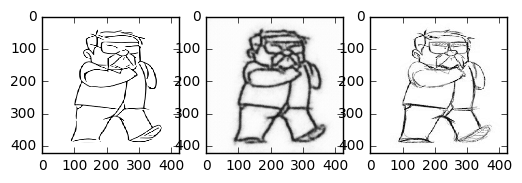

0.012117 sec


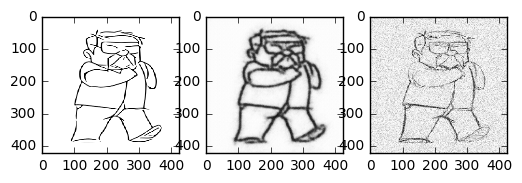

0.011948 sec


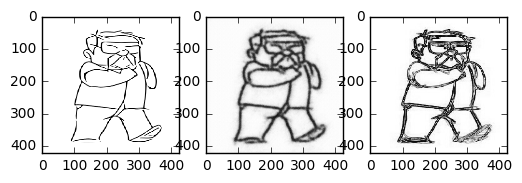

0.011671 sec


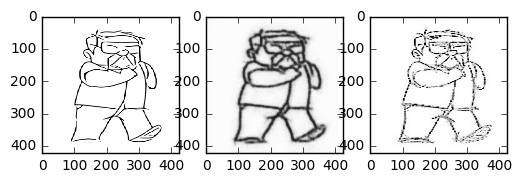

0.011625 sec


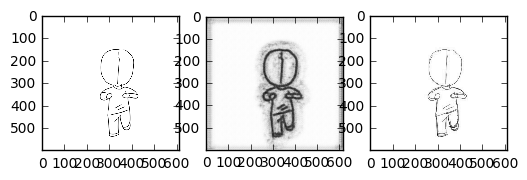

0.011472 sec


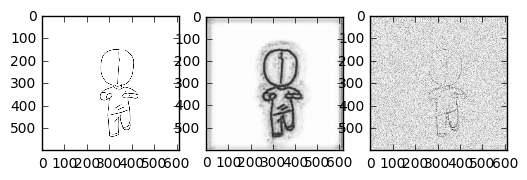

0.011612 sec


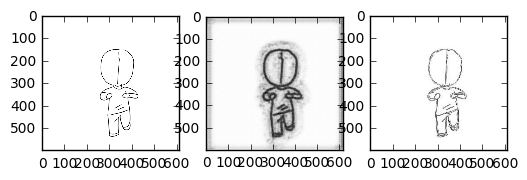

0.085023 sec


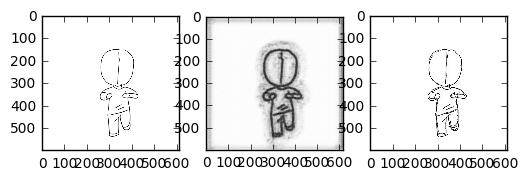

0.011879 sec


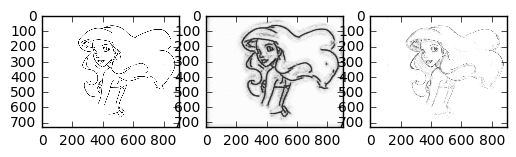

0.011736 sec


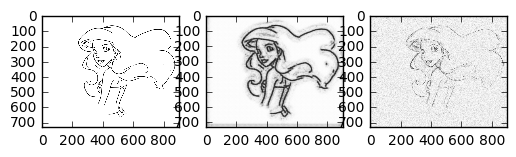

0.011638 sec


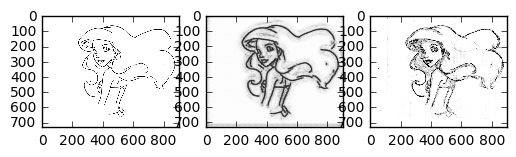

0.079174 sec


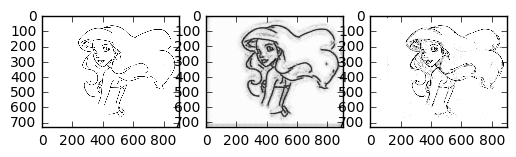

0.011625 sec


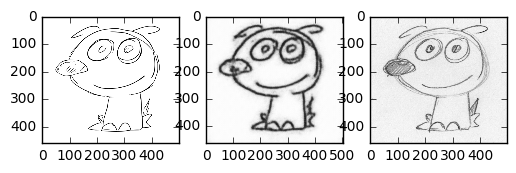

0.011462 sec


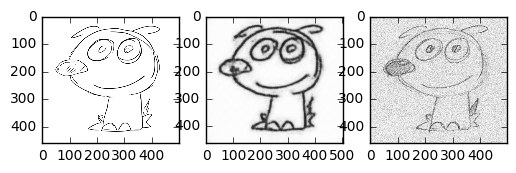

0.011650 sec


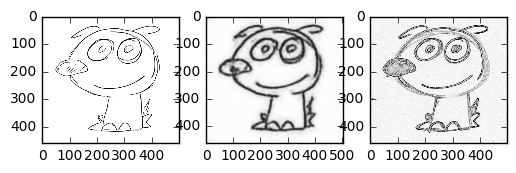

0.011535 sec


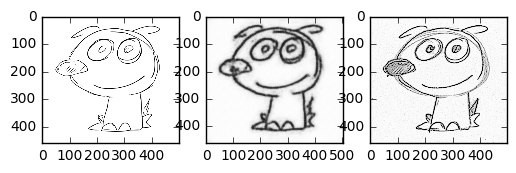

0.112872 sec


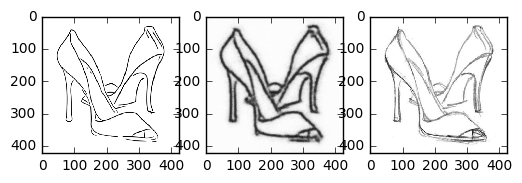

0.021214 sec


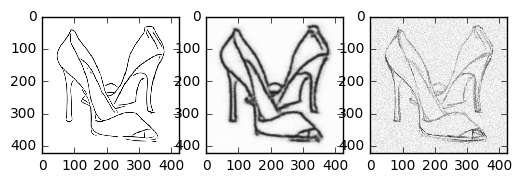

0.011924 sec


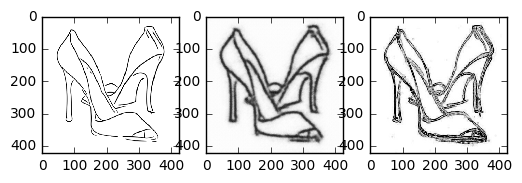

0.011582 sec


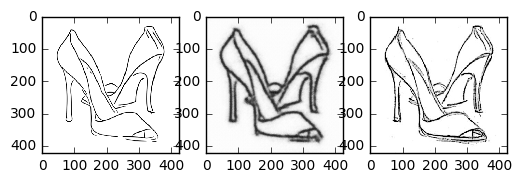

0.011610 sec


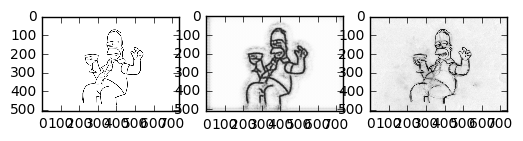

0.084403 sec


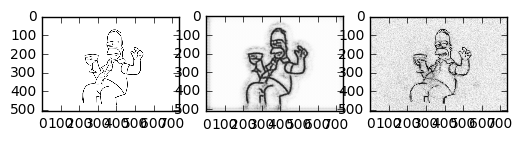

0.011754 sec


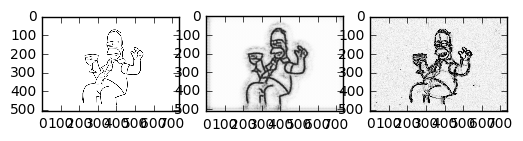

0.011652 sec


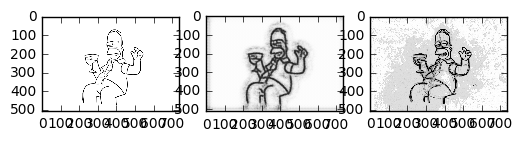

0.007819 sec


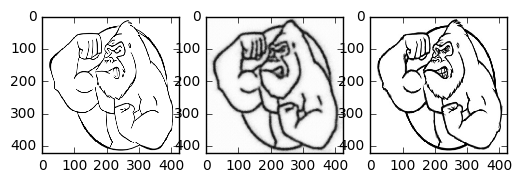

0.079081 sec


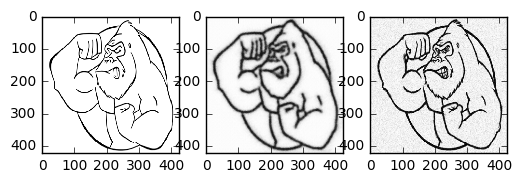

0.016166 sec


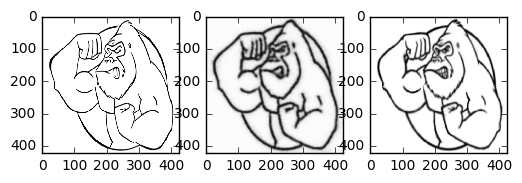

0.012130 sec


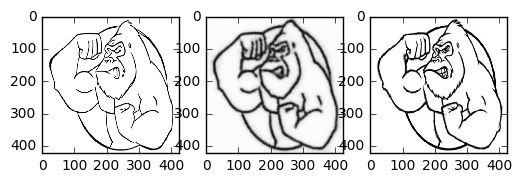

0.012237 sec


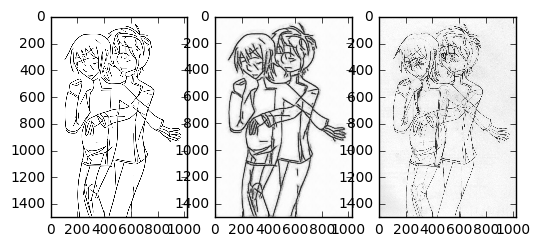

Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
0.011152 sec


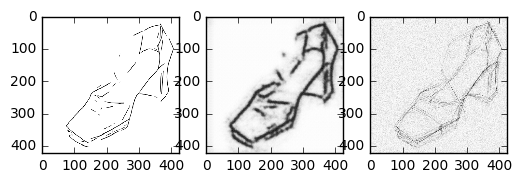

0.011559 sec


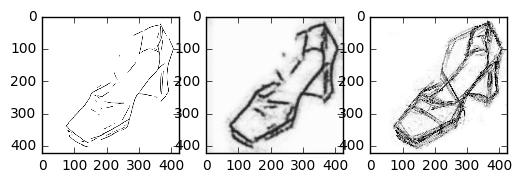

0.011539 sec


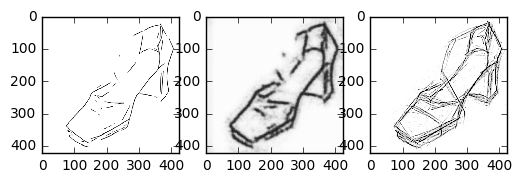

0.011686 sec


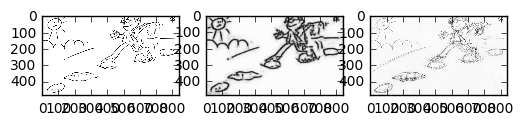

0.011423 sec


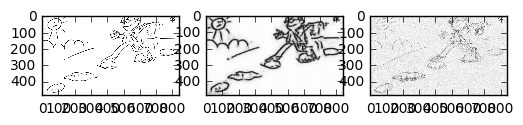

0.079009 sec


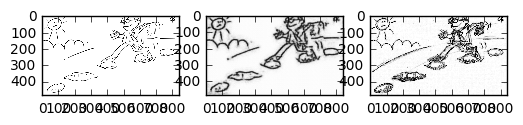

0.011626 sec


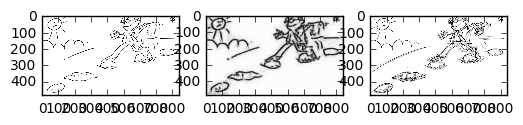

0.011530 sec


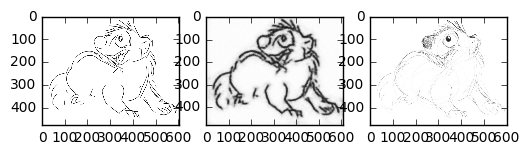

0.011531 sec


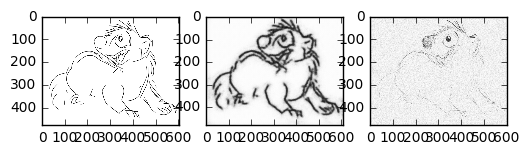

0.011580 sec


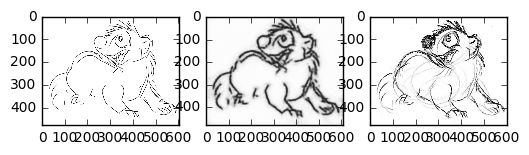

0.011795 sec


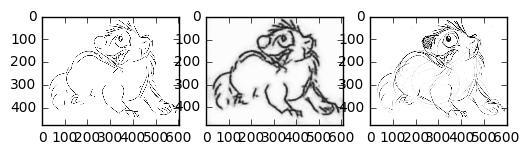

0.011690 sec


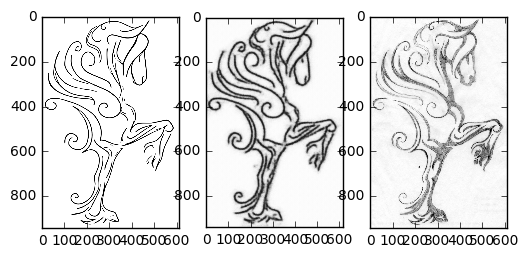

0.012172 sec


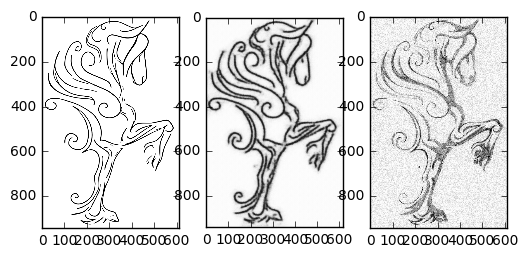

0.012142 sec


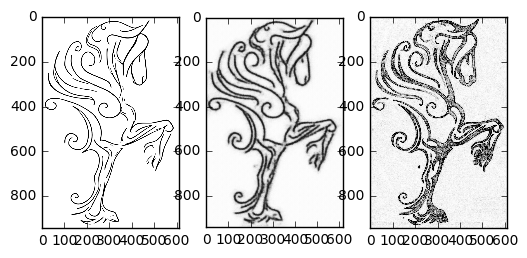

0.011614 sec


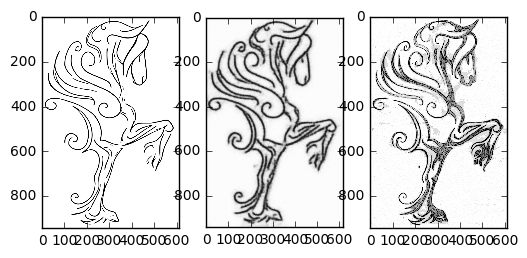

0.085822 sec


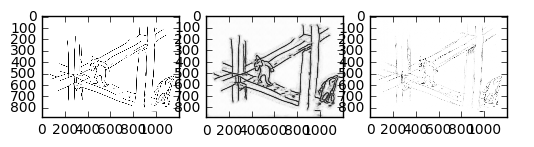

Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
0.011848 sec


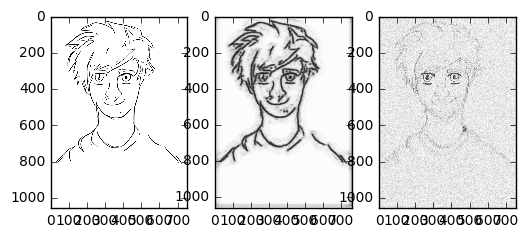

0.011667 sec


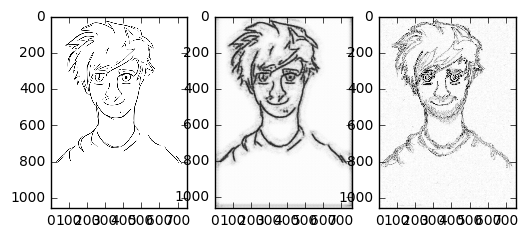

0.011695 sec


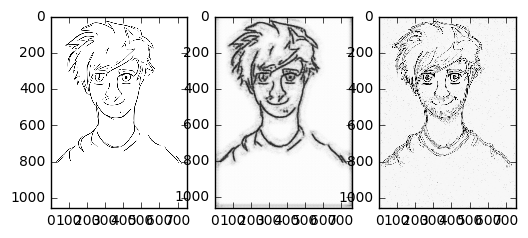

0.078265 sec


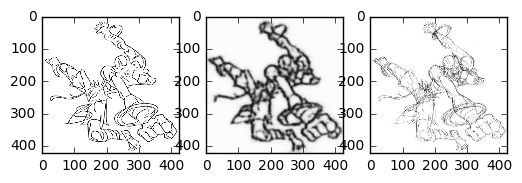

0.011706 sec


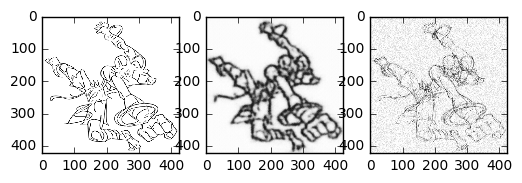

0.011573 sec


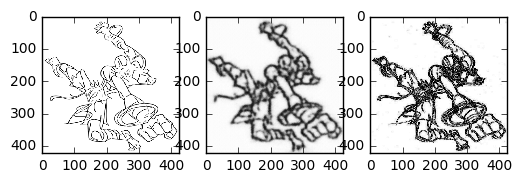

0.011561 sec


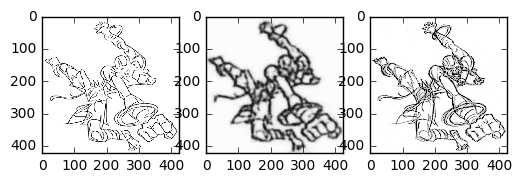

Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!
Out of Memory!


In [34]:
#------------------------------show val list results
import numpy as np
test_data=MyDataset(root+'train2.txt', -1, 1,transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_data, batch_size=1)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
idx = 0
for batch_x, batch_y in test_loader:
    batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
    try:
        start = time()
        out = model(batch_x)
        pred = out
        print('%.6f sec'%(time()-start))
        _,figs = plt.subplots(1,3)
        for i in range(len(batch_x)):
            img = (batch_x[i].cpu().data.numpy() * 255)[0,:,:]
            predimg = (pred[i].cpu().data.numpy() * 255)[0,:,:]
            gtimg = (batch_y[i].cpu().data.numpy() * 255)[0,:,:]
            figs[0].imshow(img,cmap = 'gray')
            figs[1].imshow(predimg,cmap = 'gray')
            figs[2].imshow(gtimg,cmap = 'gray')

            pilimg = Image.fromarray(np.uint8(img))
            pilimg.save('pred/' + str(idx)+'.png')

            pilimg = Image.fromarray(np.uint8(predimg))
            pilimg.save('pred/' + str(idx)+'_pred.png')

            pilimg = Image.fromarray(np.uint8(gtimg))
            pilimg.save('pred/' + str(idx)+'_gt.png')
        plt.show()
        idx = idx+1
    except:
        print('Out of Memory!')
        continue